# Packages

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from statsmodels.stats.proportion import proportions_ztest
from tqdm.auto import tqdm


# Power Analysis

## Treatment Effect
We estimate a treatment effect from a laboratory study and then "discount" this effect, informed by how other misinformation effects decayed in the field vs the lab. 

- A laboratory experiment (Kaiser et al (2022)) asked users to imagine that somebody the participant followed posted misinformation. Then the study asked participant's to rate their intentions to unfollow that individual on a scale of 1-6, with 1 being unfollowing "does not at all apply" and 6 being "does fully apply". Summing the percentage of respondents who answered 4-6 is a rough measure of the percentage of respondent's who would be more likely than not to unfollow. That sum is ~19%.

- One study (Lin et al 2024) compared the effect size of accuracy nudges in the lab to the effect size of accurarcy nudges when used in a digital ad experiment similar to ours. We use this ratio to inform how much to discount Kaiser et al. (2022). From page 11, we use the lower bound of the ad efficacy (2.6%) and the upper bound of the lab estimate (10%) to arrive at a base discount factor of (1 - 2.6/10) 74%. Doing so would yield 26% of 19%  = 5%. So we sample treatment unfollowing proportions centered at 5% (which is the base case)

## Control Rate
- Ashkinaze et al (2024) looked at the unfollowing rate of health misinformation spreaders and found it was 0.52% per month (95% CI = [0.46%, 0.58%]) so we take the upper bound of this CI as the monthly rate

- We then assume the effective control unfollowing rate would be monthly_rate / months = (monthly_rate / (n_days/30))

Running simulations:   0%|          | 0/1800 [00:00<?, ?it/s]

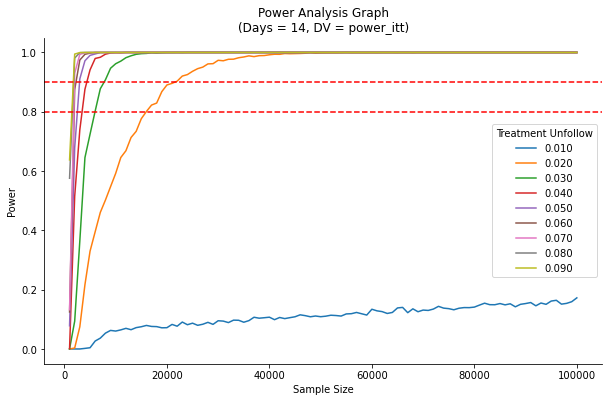

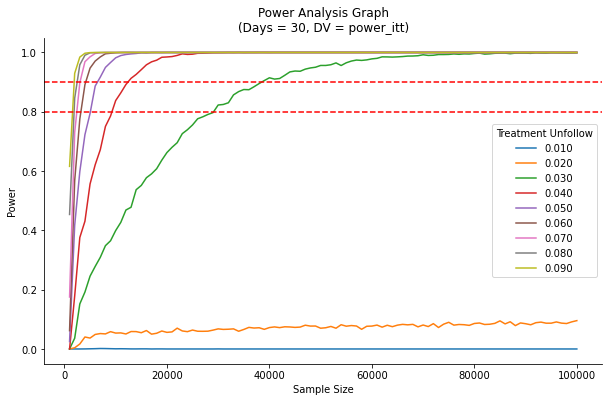

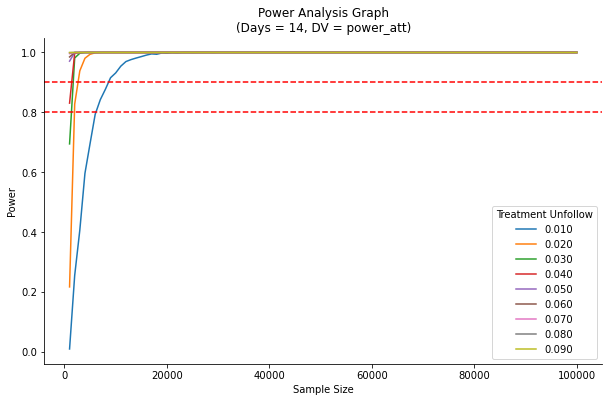

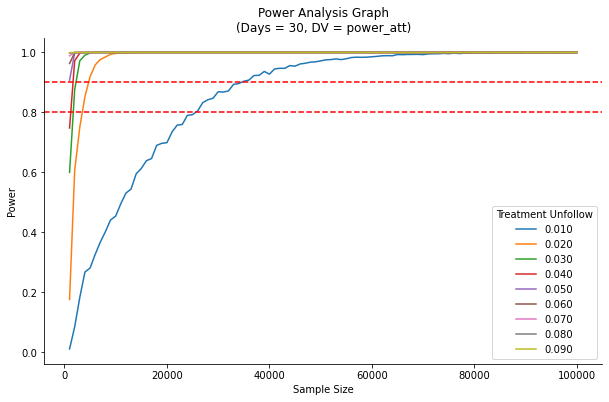

PRINTING RESULTS FOR MIN N AT 80% POWER FOR: power_itt
   treatment_prop      N treatment_prop_label
0            0.02  16000                0.020
1            0.03   6000                0.030
2            0.04   4000                0.040
3            0.05   3000                0.050
4            0.06   2000                0.060
5            0.07   2000                0.070
6            0.08   2000                0.080
7            0.09   2000                0.090
PRINTING RESULTS FOR MIN N AT 80% POWER FOR: power_att
   treatment_prop     N treatment_prop_label
0            0.01  7000                0.010
1            0.02  2000                0.020
2            0.03  2000                0.030
3            0.04  1000                0.040
4            0.05  1000                0.050
5            0.06  1000                0.060
6            0.07  1000                0.070
7            0.08  1000                0.080
8            0.09  1000                0.090
None


In [53]:
def process_task(control_prop, treatment_prop, n_days, N, treat_eligible, n_simulations, df):
    adj_control_prop = control_prop * (n_days / 30)
    power = estimate_power(df=df, N=N, 
                           control_prop=adj_control_prop, 
                           treatment_prop=treatment_prop, 
                           treat_eligible=treat_eligible, 
                           n_simulations=n_simulations, alpha=0.05)
    return {'control_prop': control_prop, 'treatment_prop': treatment_prop, 'n_days': n_days, 'N': N, 'power_itt': power['itt_power'], 'power_att':power['att_power']}


def run_power_analysis(params, df):
    tasks = [(control_prop, treatment_prop, n_days, N, params['treat_eligible'][0], params['n_simulations'], df)
             for control_prop in params['control_prop']
             for treatment_prop in params['treatment_prop']
             for n_days in params['n_days']
             for N in params['N_values']]
    
    results = Parallel(n_jobs=-1)(delayed(process_task)(*task) for task in tqdm(tasks, desc='Running simulations'))
    
    df_results = pd.DataFrame(results)
    return df_results

def estimate_power(df, N, control_prop, treatment_prop, treat_eligible, alpha=0.05, n_simulations=100):
    df_sample = df.sample(N, replace=False)
    N_control = df_sample[df_sample['treated'] == 0].shape[0]
    N_treatment = df_sample[df_sample['treated'] == 1].shape[0]
    sig_itt = 0
    sig_att = 0
    for i in range(n_simulations):
        res_dict = difference_in_proportions_test(N_control, N_treatment, treat_eligible,  control_prop, treatment_prop, alpha)
        itt_res, att_res = res_dict['itt'], res_dict['att']
        if itt_res:
            sig_itt +=1
        if att_res:
            sig_att +=1

    power = {'itt_power':sig_itt/n_simulations, "att_power":sig_att/n_simulations}
    return power

def difference_in_proportions_test(N_control, N_treatment, treat_eligible, control_prop, treatment_prop, alpha=0.05):

    # Only `treat_eligible' prop complies 
    n_treatment_compliers = int(N_treatment*treat_eligible)
    n_treatment_noncompliers = N_treatment - n_treatment_compliers
    
    # We only observe outcomes among compliers 
    control_outcomes = np.random.binomial(1, control_prop, size=N_control)
    treatment_complier_outcomes = np.random.binomial(1, treatment_prop, size=n_treatment_compliers)
    
    # Continuity correction in case 0
    success_control =  max(control_outcomes.sum(),1)
    success_treatment = max(treatment_complier_outcomes.sum(),1)
   
    # ATT uses compliers as the denominator
    count = np.array([success_treatment, success_control])  
    nobs = np.array([n_treatment_compliers, N_control])  
    att_z_stat, att_p_value = proportions_ztest(count=count, nobs=nobs, alternative='larger')
    att_res = (att_p_value <= alpha)
    
    # ITT uses total treated users as the denominator 
    count = np.array([success_treatment, success_control])  
    nobs = np.array([N_treatment, N_control])  
    itt_z_stat, itt_p_value = proportions_ztest(count=count, nobs=nobs, alternative='larger')
    itt_res = (itt_p_value <= alpha)
    
    return {'itt':itt_res, 'att':att_res}


def make_graph(df_results):
    df_results['treatment_prop_label'] = df_results['treatment_prop'].apply(lambda x: f"{x:.3f}")
    for dv in ['power_itt', 'power_att']:
        for n_days in df_results['n_days'].unique():  
            plt.figure(figsize=(10, 6))
            title = "Power Analysis Graph\n(Days = {}, DV = {})".format(n_days, dv)
            plt.title(title)
            sns.lineplot(data=df_results[df_results['n_days'] == n_days], 
                         x="N", 
                         y=dv, 
                         hue="treatment_prop_label")
            plt.axhline(y=0.8, linestyle='dashed', color='red')  
            plt.axhline(y=0.9, linestyle='dashed', color='red')  

            plt.legend(title="Treatment Unfollow")
            plt.xlabel("Sample Size")
            plt.ylabel("Power")
            sns.despine()
            plt.show()

def find_required_N(df_results):
    for dv in ['power_itt', 'power_att']:
        print("PRINTING RESULTS FOR MIN N AT 80% POWER FOR: {}".format(dv))
        df_filtered = df_results[df_results[dv] >= 0.8]
        df_required_N = df_filtered.groupby('treatment_prop', as_index=False)['N'].min()
        df_required_N['treatment_prop_label'] = df_required_N['treatment_prop'].apply(lambda x: f"{x:.3f}")
        print(df_required_N)



df = pd.read_csv("treat_status_MINIMAL_FOLLOWERS_03.04.2024__17.11.03__START0_END-1.csv")
params = {
    'control_prop': [0.0058],
    'treatment_prop': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09],
    'N_values': np.linspace(1000, 100000, 100, dtype=int),
    'n_days':[14, 30],
    'n_simulations': 5000,
    "treat_eligible":[0.3]
}

df_results = run_power_analysis(params, df)
make_graph(df_results)
print(find_required_N(df_results))

In [51]:
df

,Unnamed: 0,main,followers_id,group,treated
0,0,JackPosobiec,4006264589,treatment,1
1,1,JackPosobiec,371359419,control,0
2,2,JackPosobiec,1742842252320198656,treatment,1
3,3,JackPosobiec,1738557055814746112,treatment,1
4,4,JackPosobiec,1734363404456873984,treatment,1
...,...,...,...,...,...
1762283,1762283,stkirsch,1727314793575366656,treatment,1
1762284,1762284,stkirsch,297152208,treatment,1
1762285,1762285,stkirsch,1504222031587459075,treatment,1
1762286,1762286,stkirsch,1449743751786770433,treatment,1
